In [76]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp, odeint
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from tqdm import tqdm

sys.path.append('..')
from src.bioreactor import *

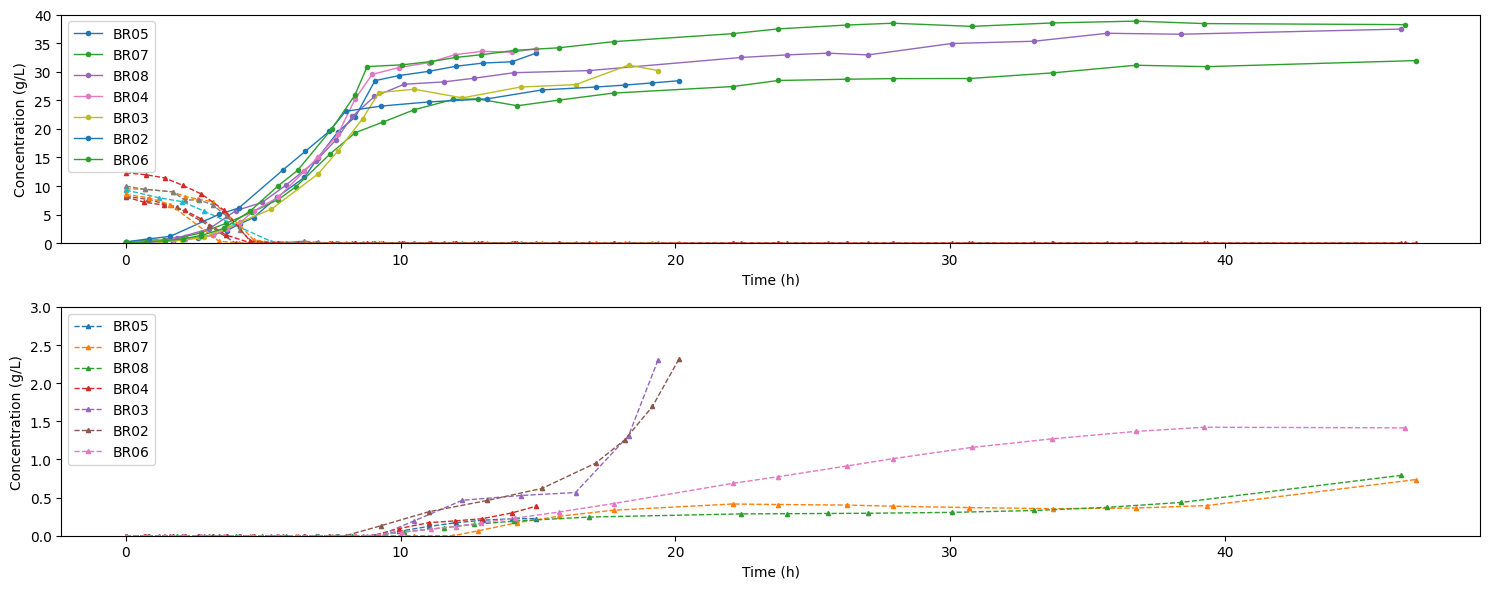

,Time,Glucose,Biomass,Protein
experiment,,,,
BR02,20.133333,8.53,28.417857,2.318808
BR03,19.366667,9.3,31.153571,2.302295
BR04,14.933333,10.0,34.017857,0.387269
BR05,14.916667,9.5,33.22381,0.225718
BR06,46.533333,12.332,38.842857,1.423235
BR07,46.933333,8.1,31.935714,0.73603
BR08,46.416667,8.209,37.453571,0.792027


In [77]:
experiments = [file.split('.')[0] for file in os.listdir('./data')]

def get_experiment(experiment: str) -> pd.DataFrame:
    path = f'./data/{experiment}.xls'
    df = pd.read_excel(path, header=0)
    df.drop(0, inplace=True)
    return df

def get_data(experiments: list) -> pd.DataFrame:
    df = pd.DataFrame()
    for exp in experiments:
        _df = get_experiment(exp)
        _df['experiment'] = exp
        df = pd.concat([df, _df])
    return df
    
# Plot all experiments 
def plot_experiments(df: pd.DataFrame, experiments: list) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(15, 6))

    for exp in experiments:
        data = df[df['experiment'] == exp]
        axes[0].plot(data['Time'], data['Biomass'], label=f'{exp}', marker='o', markersize=3, linewidth=1)
        axes[0].plot(data['Time'], data['Glucose'], label=f'_{exp}', marker='^', markersize=3, linewidth=1, linestyle='--')
        axes[1].plot(data['Time'], data['Protein'], label=f'{exp}', marker='^', markersize=3, linewidth=1, linestyle='--')

    axes[0].set_ylim(0, 40)
    axes[0].set_xlabel('Time (h)')
    axes[0].set_ylabel('Concentration (g/L)')
    axes[0].legend()

    axes[1].set_ylim(0, 3)
    axes[1].set_xlabel('Time (h)')
    axes[1].set_ylabel('Concentration (g/L)')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

df = get_data(experiments)
plot_experiments(df, experiments)

display(df.groupby('experiment').max()[['Time', 'Glucose', 'Biomass', 'Protein']])

In [78]:
# Get data for a specific experiment
data = df[df['experiment'] == 'BR07']

In [79]:
# ----- Constants -----
# Num of samples0
NUM_SAMPLES = 100

# Kinetic parameters
MU_MAX = 0.810623399       # 1/h
K_S    = 0.000103       # g/l
Y_XS   = 0.419041856       # g/g
Y_PX   = 0.2              # g/g
S_F    = 1.43 * 200       # g/l

# Initial conditions
X_0 = 5.00
S_0 = 0.01
V_0 = 1.65

# Time parameters
T_START = 0
T_END = 40
TIME_RANGE = int(T_END - T_START) # Absolute time 
TIME = np.linspace(T_START, T_END, NUM_SAMPLES) # Time vector

# MPC parameters
dt = TIME[1] - TIME[0]                         # Time step
N_p = 25                                       # Prediction horizon
Q = 10                                        # Weight for tracking
Q_term = 0.0                                   # Weight for terminal state
R = 0.1                                        # Weight for control effort
OPTIMIZATION_METHOD = 'SLSQP' # Optimization method. Other options: 'SLSQP, 'L-BFGS-B', 'trust-constr', 'COBYLA', 'Powell', 'Nelder-Mead'

# Bounds for feeding rate
F_MIN = 0.0                  # l/h
F_MAX = 0.1                  # l/h
DELTA_F_MAX = 0.05           # Maximum change in feed rate
F_0 = (F_MAX - F_MIN) / 2    # Initial feed rate
BOUNDS = [(F_MIN, F_MAX) for _ in range(N_p)] 

# Constraints for volume and substrate concentration
V_MAX = 2.0  # Maximum volume
S_MAX = 2 # Maximum substrate concentration
w_S = 0.0    # Weight for substrate constraint
w_V = 0.0    # Weight for volume constraint

# Initial conditions
X = np.zeros_like(TIME)
S = np.zeros_like(TIME)
V = np.zeros_like(TIME)
F = np.zeros_like(TIME)
X[0], S[0], V[0] = X_0, S_0, V_0

# Setpoint
X_SP = 25

# Cost function
def objective(F_seq, X_curr, S_curr, V_curr):
    X_pred, S_pred, V_pred = X_curr, S_curr, V_curr
    cost = 0
    F_prev = F[i]
    for j in F_seq:
        X_pred, S_pred, V_pred = discretized_model(TIME[i], X_pred, S_pred, V_pred, j, h=dt)
        cost += Q * (X_pred - X_SP) ** 2 
        cost += R * (j - F_prev) ** 2
        F_prev = j
    return cost

for i in tqdm(range(len(TIME)-1)):
    res = minimize(objective, np.ones(N_p) * F[i], args=(X[i], S[i], V[i]), bounds=BOUNDS, method=OPTIMIZATION_METHOD)
    F_new = res.x[0]
    F[i+1] = F_new
    F[i + 1] = np.clip(F[i] + np.clip(F_new - F[i], -DELTA_F_MAX, DELTA_F_MAX), F_MIN, F_MAX)  # Enforce Δp ≤ 20
    X[i+1], S[i+1], V[i+1] = discretized_model(TIME[i], X[i], S[i], V[i], F_new, h=dt)

 21%|██        | 21/99 [00:00<00:00, 209.83it/s]

100%|██████████| 99/99 [00:00<00:00, 228.27it/s]


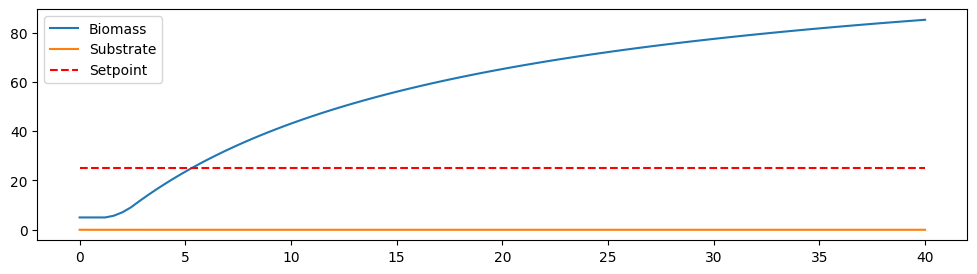

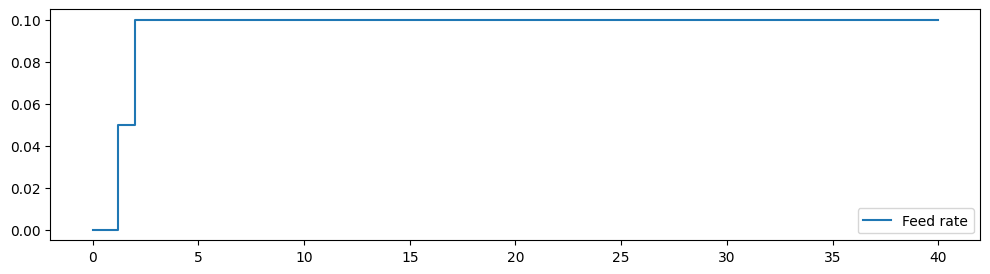

In [80]:
############ Evaluation #############
############# Simulate system using ODEs / kinetic parameters / IC #############
def plant_model(t, y, F_func: callable):
    X, S, V = y
    F = F_func(t)
    dX_dt = (MU_MAX * S / (K_S + S)) * X - (F / V) * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (F / V) * (S_F - S)
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]

# Solve plant model for varying feed rates
F_func = interp1d(TIME, F, kind='linear', fill_value='extrapolate')
sol = solve_ivp(plant_model, [T_START, T_END], [X_0, S_0, V_0], args=(F_func,), method='LSODA', t_eval=TIME, rtol=1e-6, atol=1e-12)

plt.figure(figsize=(12, 3))
plt.plot(sol.t, sol.y[0], label='Biomass')
plt.plot(sol.t, sol.y[1], label='Substrate')
plt.plot(sol.t, X_SP * np.ones_like(sol.t), 'r--', label='Setpoint')
plt.legend()
plt.show()

plt.figure(figsize=(12, 3))
plt.step(TIME, F, label='Feed rate')
plt.legend()
plt.show()

Experiment simulation

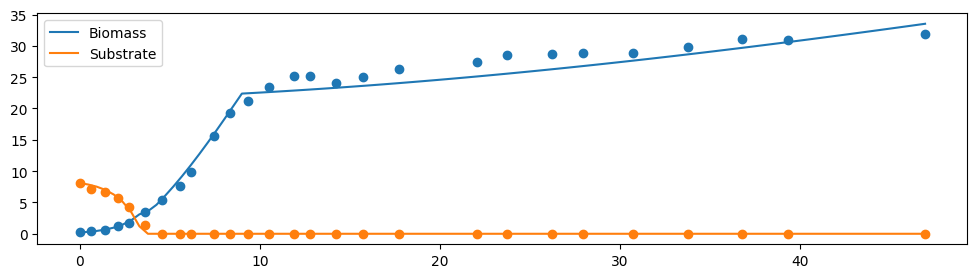

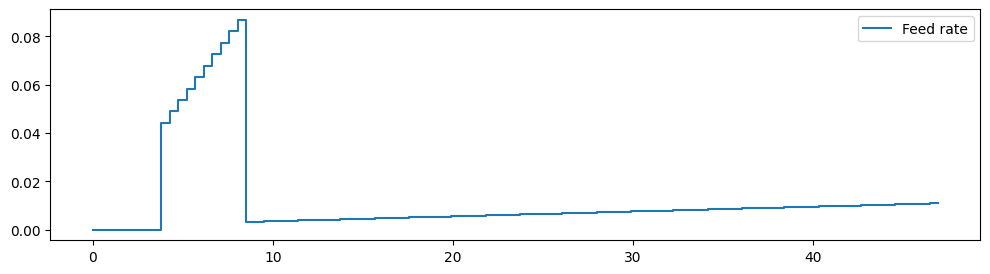

In [81]:
T_START = data['Time'].min()
T_END = data['Time'].max()
TIME = np.linspace(T_START, T_END, NUM_SAMPLES)
X_0 = data['Biomass'].iloc[0]
S_0 = data['Glucose'].iloc[0]
V_0 = data['Vreal'].iloc[0]

def Fs(t: float, experiment: str = 'BR07') -> float:
    conditions = {
        'BR02': [(3.4, 8, 0.013, 0.0001)],
        'BR03': [(4.8, 9.3, 0.011, 0.0006)],
        'BR04': [(4.45, 9, 0.006, 0.00005)],
        'BR05': [(5.6, 9.1, 0.006, 0.00005)],
        'BR06': [(4.3, 9, 0.013, 0.0003)],
        'BR07': [(3.9, 9, 0.01, 0.0002)],
        'BR08': [(3.6, 10, 0.01, 0.0002)]
    }
    
    if experiment in conditions:
        start, end, slope1, slope2 = conditions[experiment][0]
        if t <= start:
            return 0
        elif start < t <= end:
            return slope1 * t + 0.0015
        else:
            return slope2 * t + 0.0015
    return 0

sol = solve_ivp(plant_model, [T_START, T_END], [X_0, S_0, V_0], args=(Fs,), method='LSODA', t_eval=TIME, rtol=1e-6, atol=1e-12)

plt.figure(figsize=(12, 3))
plt.plot(sol.t, sol.y[0], label='Biomass')
plt.scatter(data['Time'], data['Biomass'], label='_Biomass')
plt.plot(sol.t, sol.y[1], label='Substrate')
plt.scatter(data['Time'], data['Glucose'], label='_Glucose')
plt.legend()
plt.show()

plt.figure(figsize=(12, 3))
plt.step(TIME, [Fs(t) for t in TIME], label='Feed rate')
plt.legend()
plt.show()